Objective: itakura_saito_distance
Optimizer: dual_annealing


dual_annealing optimizing:   0%|           0/500 [ETA: ?, Elapsed: 00:00]

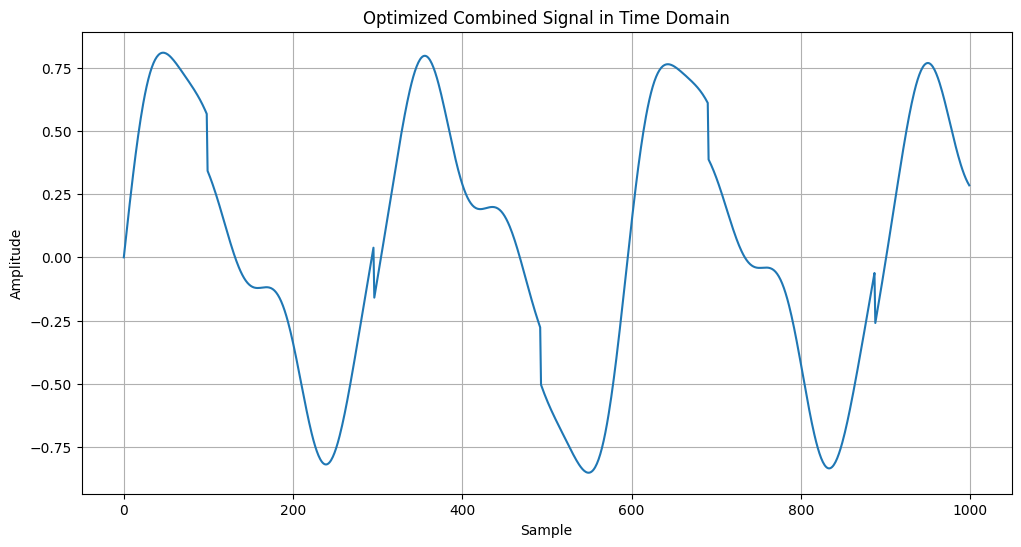

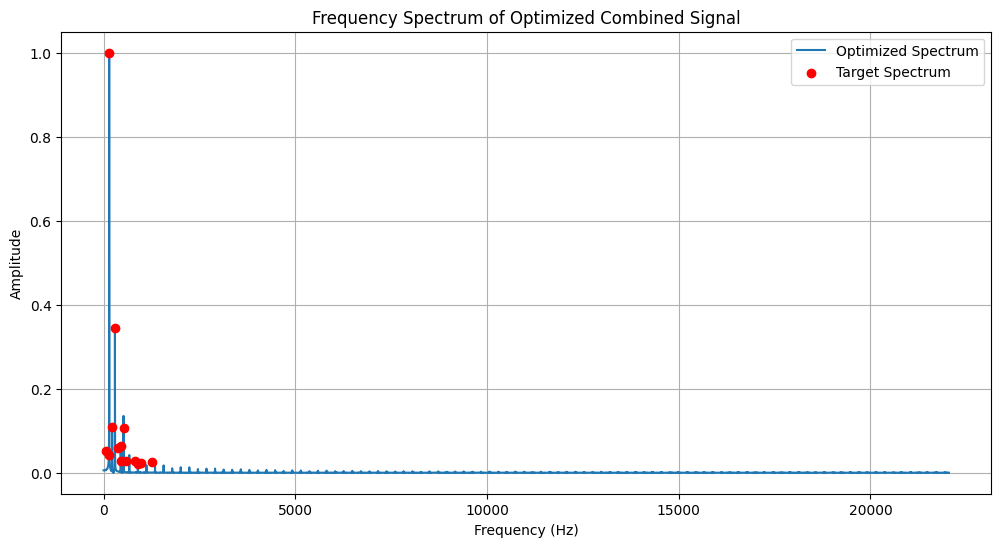

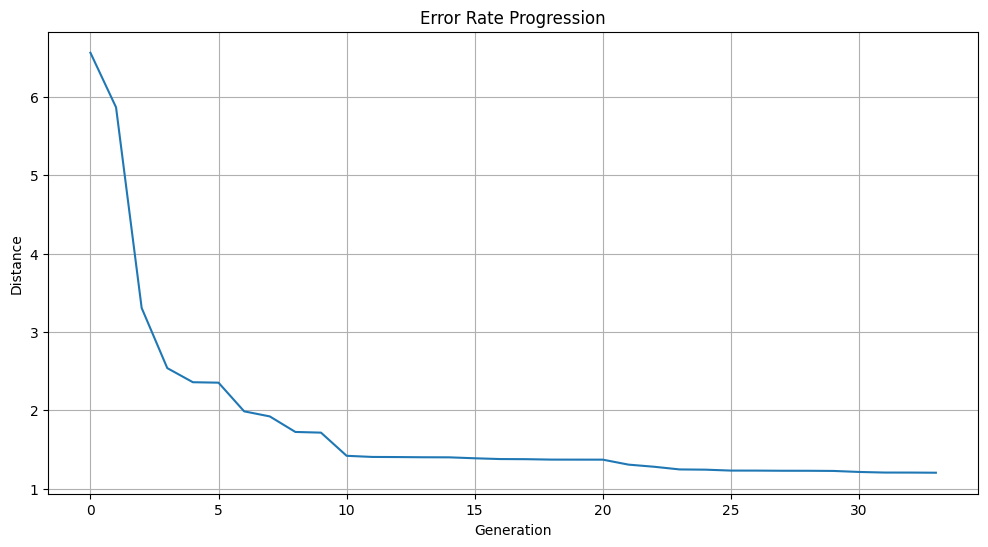

Optimal Frequencies: [201.38829997 283.356435   529.36656521 160.56160378]
Optimal Amplitudes: [0.12350707 0.26996389 0.08330064 0.77059086]
Optimal Waveforms: ['sawtooth_wave', 'sine_wave', 'sine_wave', 'sine_wave']
[2025-08-28 03:24:34] 16-bit wave file with 44.1kHz sampling rate saved successfully to: c:\Users\egorp\Nextcloud\code\public_repos\FFTimbre\rendered_audio\optimized_output_cellotest.wav


In [5]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, basinhopping, dual_annealing
from tqdm.auto import tqdm
from IPython.display import Audio, display
from py_scripts.objective_functions import (
    itakura_saito_distance,
    cosine_similarity,
    spectral_convergence_distance,
    euclidean_distance,
    manhattan_distance,
    kullback_leibler_divergence,
    pearson_correlation_coefficient,
    mfcc_distance
)
from py_scripts.waveform_generators import sine_wave, square_wave, triangle_wave, sawtooth_wave, noise_wave
from py_scripts.generate_wave_file import generate_wave_file

# Check if the file exists
file_path = 'tsv/cello_single.tsv'
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File {file_path} does not exist.")

# Load TSV file into a DataFrame
df = pd.read_csv(file_path, sep='\t')

# Extract frequencies and amplitudes
frequencies = df['Frequency (Hz)'].values
amplitudes = df['Amplitude'].values

# Normalize amplitudes
amplitudes /= np.max(amplitudes)

# Parameters
duration = 1.0  # seconds
sample_rate = 44100  # samples per second

waveforms = [sine_wave, square_wave, triangle_wave, sawtooth_wave, noise_wave]

# Choose the objective function
objective = itakura_saito_distance # options: itakura_saito_distance, cosine_similarity, spectral_convergence_distance, euclidean_distance, manhattan_distance, kullback_leibler_divergence, pearson_correlation_coefficient, mfcc_distance

# Choose the optimization algorithm
optimization_algorithm = 'dual_annealing'  # options: 'differential_evolution', 'basinhopping', 'dual_annealing'

# Print selected configuration before starting optimization
print(f"Objective: {objective.__name__}")
print(f"Optimizer: {optimization_algorithm}")

# Optimization constraints
max_oscillators = 4
bounds = [(50, 5000), (0, 1), (0, len(waveforms) - 1)] * max_oscillators

# Initialize tqdm progress bar and error history
n_generations = 500

progress = tqdm(
    total=n_generations,
    unit=' iteration',
    desc=f"{optimization_algorithm} optimizing",
    bar_format='{l_bar}{bar} {n}/{total} [ETA: {remaining}, Elapsed: {elapsed}]'
)
error_history = []

# Callback function to update progress bar and error history
def callback(param, f):
    error = objective(param, frequencies, amplitudes, waveforms, duration, sample_rate)
    error_history.append(error)
    progress.update(1)

# Define optimization functions
def run_differential_evolution():
    return differential_evolution(
        objective, bounds, args=(frequencies, amplitudes, waveforms, duration, sample_rate), 
        strategy='best1bin', maxiter=n_generations, popsize=10, tol=1e-6, 
        mutation=(0.5, 1), recombination=0.7, callback=callback
    )

def run_basinhopping():
    class MyBounds:
        def __init__(self, bounds):
            self.bounds = np.array(bounds)
        def __call__(self, **kwargs):
            x = kwargs["x_new"]
            tmax = np.all(x <= self.bounds[:, 1])
            tmin = np.all(x >= self.bounds[:, 0])
            return tmax and tmin

    mybounds = MyBounds(bounds)
    minimizer_kwargs = {
        'method': 'L-BFGS-B',
        'args': (frequencies, amplitudes, waveforms, duration, sample_rate),
        'bounds': bounds
    }
    
    def step_callback(x, f, accept):
        callback(x, f)
    
    initial_guess = np.array([np.random.uniform(low, high) for low, high in bounds])
    
    return basinhopping(
        objective, x0=initial_guess, niter=n_generations, accept_test=mybounds, 
        minimizer_kwargs=minimizer_kwargs, callback=step_callback
    )

def run_dual_annealing():
    return dual_annealing(
        objective, bounds, args=(frequencies, amplitudes, waveforms, duration, sample_rate), 
        maxiter=n_generations, callback=lambda x, f, context: callback(x, f)
    )

# Run the selected optimization algorithm
optimizers = {
    'differential_evolution': run_differential_evolution,
    'basinhopping': run_basinhopping,
    'dual_annealing': run_dual_annealing,
}
if optimization_algorithm not in optimizers:
    raise ValueError(f"Unknown optimization algorithm: {optimization_algorithm}")
result = optimizers[optimization_algorithm]()

# Close progress bar
progress.close()

# Extract optimal parameters
optimal_params = result.x

optimal_frequencies = optimal_params[0::3]
optimal_amplitudes = optimal_params[1::3]
optimal_waveform_indices = optimal_params[2::3].astype(int)

# Generate combined signal using optimal parameters
combined_signal = np.zeros(int(sample_rate * duration))
for freq, amp, waveform_index in zip(optimal_frequencies, optimal_amplitudes, optimal_waveform_indices):
    if np.isnan(waveform_index) or waveform_index < 0 or waveform_index >= len(waveforms):
        continue
    closest_freq_index = np.argmin(np.abs(frequencies - freq))
    matched_freq = frequencies[closest_freq_index]
    waveform = waveforms[waveform_index]
    combined_signal += waveform(matched_freq, amp, duration, sample_rate)

# Normalize combined signal
combined_signal /= np.max(np.abs(combined_signal))

# Compute FFT for plotting
fft_result = np.fft.fft(combined_signal)
fft_freqs = np.fft.fftfreq(len(fft_result), 1/sample_rate)

# Normalize the FFT result for comparison
fft_result_np = np.abs(fft_result)
fft_result_np /= np.max(fft_result_np)

# Plot results
def plot_results():
    # Time domain plot
    plt.figure(figsize=(12, 6))
    plt.plot(combined_signal[:1000])  # Plot the first 1000 samples
    plt.title('Optimized Combined Signal in Time Domain')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

    # Frequency domain plot
    plt.figure(figsize=(12, 6))
    plt.plot(fft_freqs[:len(fft_freqs)//2], fft_result_np[:len(fft_result_np)//2], label='Optimized Spectrum')
    plt.scatter(frequencies, amplitudes, color='red', label='Target Spectrum', zorder=5)
    plt.title('Frequency Spectrum of Optimized Combined Signal')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot error history
    plt.figure(figsize=(12, 6))
    plt.plot(error_history)
    plt.title('Error Rate Progression')
    plt.xlabel('Generation')
    plt.ylabel('Distance')
    plt.grid(True)
    plt.show()

plot_results()

# Print optimal parameters
print("Optimal Frequencies:", optimal_frequencies)
print("Optimal Amplitudes:", optimal_amplitudes)
print("Optimal Waveforms:", [waveforms[i].__name__ for i in optimal_waveform_indices])

# Synthesize and save the audio using the provided script
output_filename = 'optimized_output_cellotest.wav'
generate_wave_file(combined_signal, sample_rate, custom_filename=output_filename, save_to_file=True)

output_path = os.path.join('rendered_audio', output_filename)
display(Audio(filename=output_path))


In [6]:
# Define the filename
tsv_filename = 'tsv/final_values_additive.tsv'

# Create the DataFrame
final_values_df = pd.DataFrame({
    'Modulator': [1, 2, 3, 4],
    'Frequency (Hz)': optimal_frequencies[::-1],
    'Amplitude': optimal_amplitudes[::-1],
    'Waveform': [waveforms[i].__name__ for i in optimal_waveform_indices]
})

# Display the DataFrame
display(final_values_df)

# Save the DataFrame as a TSV file
final_values_df.to_csv(tsv_filename, sep='\t', index=False)

# Print the location where the TSV file was saved
print(f"TSV file was saved at: {os.path.abspath(tsv_filename)}")

,Modulator,Frequency (Hz),Amplitude,Waveform
0,1,160.561604,0.770591,sawtooth_wave
1,2,529.366565,0.083301,sine_wave
2,3,283.356435,0.269964,sine_wave
3,4,201.388300,0.123507,sine_wave


TSV file was saved at: c:\Users\egorp\Nextcloud\code\public_repos\FFTimbre\tsv\final_values_additive.tsv


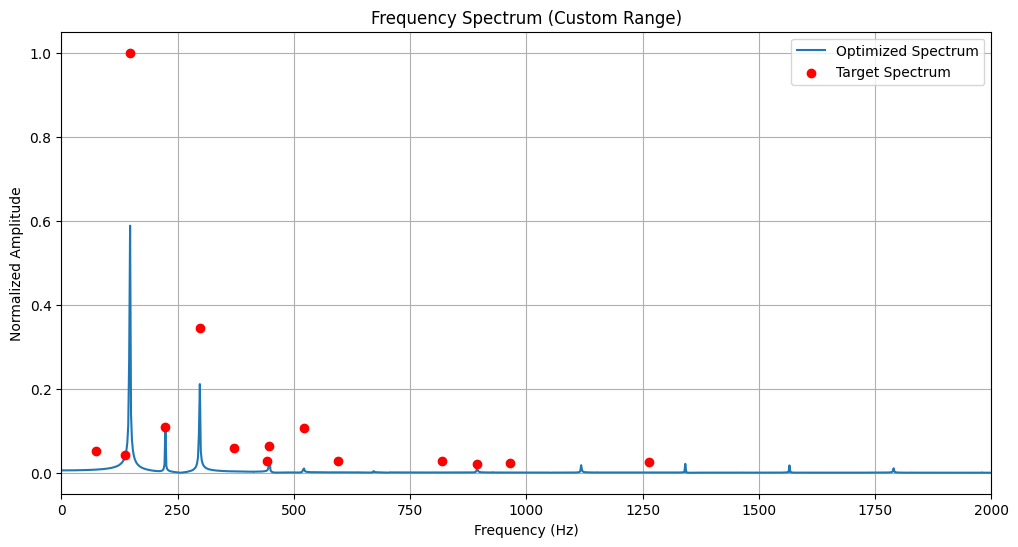

In [7]:
# Frequency-domain plot with customizable range and x-resolution
# Set your desired frequency range and plotting step in Hz
freq_min = 0.0      # Hz
freq_max = 2000.0   # Hz
plot_step_hz = 2.0  # Downsample plotted FFT points to roughly this spacing

# Prepare positive-frequency spectrum
positive_mask = (fft_freqs >= 0)
freqs_pos = fft_freqs[positive_mask]
spectrum_pos = fft_result_np[positive_mask]

# Filter by desired range
range_mask = (freqs_pos >= freq_min) & (freqs_pos <= freq_max)
freqs_range = freqs_pos[range_mask]
spectrum_range = spectrum_pos[range_mask]

# Compute bin spacing and downsample for plotting density control
if len(freqs_pos) > 1:
    bin_spacing_hz = freqs_pos[1] - freqs_pos[0]
else:
    bin_spacing_hz = 0.0

if plot_step_hz is not None and plot_step_hz > 0 and bin_spacing_hz > 0:
    step_n = max(1, int(round(plot_step_hz / bin_spacing_hz)))
else:
    step_n = 1

freqs_plot = freqs_range[::step_n]
spectrum_plot = spectrum_range[::step_n]

# Target spectrum in range
if 'frequencies' in globals() and 'amplitudes' in globals():
    target_mask = (frequencies >= freq_min) & (frequencies <= freq_max)
    target_freqs = frequencies[target_mask]
    target_amps = amplitudes[target_mask]
else:
    target_freqs = np.array([])
    target_amps = np.array([])

plt.figure(figsize=(12, 6))
plt.plot(freqs_plot, spectrum_plot, label='Optimized Spectrum')
if target_freqs.size > 0:
    plt.scatter(target_freqs, target_amps, color='red', label='Target Spectrum', zorder=5)
plt.title('Frequency Spectrum (Custom Range)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Normalized Amplitude')
plt.xlim(freq_min, freq_max)
plt.grid(True)
plt.legend()
plt.show()


In [8]:
# Render a longer version of the optimized sound with configurable duration (seconds)
# Set desired duration in seconds for the rendered audio
render_duration_sec = 10.0  # e.g., 5 seconds
fs_render = sample_rate     # base rate prior to resampling in generate_wave_file

# Re-synthesize the optimized combined signal for the new duration
num_samples = int(fs_render * render_duration_sec)
long_signal = np.zeros(num_samples)

t = np.arange(num_samples) / fs_render
for freq, amp, waveform_index in zip(optimal_frequencies, optimal_amplitudes, optimal_waveform_indices):
    if np.isnan(waveform_index) or waveform_index < 0 or waveform_index >= len(waveforms):
        continue
    closest_freq_index = np.argmin(np.abs(frequencies - freq))
    matched_freq = frequencies[closest_freq_index]
    waveform = waveforms[waveform_index]
    # Call waveform generator directly for the new duration
    long_signal += waveform(matched_freq, amp, render_duration_sec, fs_render)

# Normalize
long_signal /= np.max(np.abs(long_signal))

# Save using existing utility (keeps consistent pathing and format)
long_output_filename = f"optimized_output_cellotest_long_{int(render_duration_sec)}s.wav"
file_path = generate_wave_file(long_signal, fs_render, custom_filename=long_output_filename, save_to_file=True)

display(Audio(filename=file_path))


[2025-08-28 03:24:58] 16-bit wave file with 44.1kHz sampling rate saved successfully to: c:\Users\egorp\Nextcloud\code\public_repos\FFTimbre\rendered_audio\optimized_output_cellotest_long_10s.wav
